
    
# **Preliminary Results**



    
### Name: Krisha Bugajski

    
### Date: 10/5/25




## Table of Contents

    
- [**Load Libraries and Data**](#Load-libraries-and-Data)  
- [**Feature Engineering**](#Feature-Engineering)  
- [**Data Preprocessing**](#Data-Preprocessing)  
  &nbsp;&nbsp;&nbsp;&nbsp;• [Missing Values](#Missing-values)  
  &nbsp;&nbsp;&nbsp;&nbsp;• [Leakage Check](#Leakage-check)  
  &nbsp;&nbsp;&nbsp;&nbsp;• [Class Imbalance Check](#Class-Imbalance-Check)  
- [**Data Splitting and Preparation**](#Data-Splitting-and-Preparation)  
  &nbsp;&nbsp;&nbsp;&nbsp;• [Train/Test Split](#Train/Test-Split)  
  &nbsp;&nbsp;&nbsp;&nbsp;• [Train/Validation Split](#Train/Validation-Split)  
- [**Post-Split Preprocessing**](#Post-Split-Preprocessing)  
  &nbsp;&nbsp;&nbsp;&nbsp;• [Outliers](#Outliers)  
  &nbsp;&nbsp;&nbsp;&nbsp;• [Encoding](#Encoding)     
  &nbsp;&nbsp;&nbsp;&nbsp;• [Feature Scaling](#Feature-Scaling)  
  &nbsp;&nbsp;&nbsp;&nbsp;• [Convert to PyTorch Tensors](#Convert-to-PyTorch-Tensors)
- [**Build Dense Feedforward Neural Network**](#Build-Dense-Feedforward-Neural-Network)  
  &nbsp;&nbsp;&nbsp;&nbsp;• [Create TensorDataset and DataLoader](#Create-TensorDataset-and-DataLoader)  
  &nbsp;&nbsp;&nbsp;&nbsp;• [Define model with nn.Sequential](#Define-model-with-nn.Sequential)  
  &nbsp;&nbsp;&nbsp;&nbsp;• [Set Loss Function and Optimizer](#Set-Loss-Function-and-Optimizer)  
  &nbsp;&nbsp;&nbsp;&nbsp;• [Training Loop with Validation](#Training-Loop-with-Validation)  
  &nbsp;&nbsp;&nbsp;&nbsp;• [Plot Learning Curves](#Plot-Learning-Curves)   
- [**Training Evaluation**](#Training-Evaluation)   
  &nbsp;&nbsp;&nbsp;&nbsp;• [Validation Accuracy & Classification Report](#Final-Test-Accuracy-&-Classification-Report)  
- [**Final Test Evaluation**](#Final-Test-Evaluation)  
  &nbsp;&nbsp;&nbsp;&nbsp;• [Final Test Accuracy & Classification Report](#Validation-Accuracy-&-Classification-Report)  
  &nbsp;&nbsp;&nbsp;&nbsp;• [Plot Confusion Matrix](#Plot-Confusion-Matrix)  
  &nbsp;&nbsp;&nbsp;&nbsp;• [Test Set Model Predictions](#Test-Set-Model-Predictions)   
  &nbsp;&nbsp;&nbsp;&nbsp;• [Calculate Information for ROC curve](#Calculate-Information-for-ROC-curve)   
  &nbsp;&nbsp;&nbsp;&nbsp;• [Plot ROC curve](#Plot-ROC-curve)   
- [**Neural Network Design Rationale**](#Neural-Network-Design-Rationale)   
- [**Future Improvements and Next Steps**](#Future-Improvements-and-Next-Steps) 
  

# Load libraries and Data

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import random
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from IPython.display import display, HTML
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder


# Loading Data
file_path = "/Users/krishabugajski/Desktop/Machine_Learing+Artificial_Inte/Project/project_data.csv"

# Load csv
customer = pd.read_csv(file_path)

# Visualize the Original Dataset
pd.set_option('display.max_columns', None)
customer.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,meal_plan_1,0,room_type1,224,2017-10-02,offline,0,0,0,65.00,0,not_canceled
1,INN00002,2,0,2,3,not_selected,0,room_type1,5,2018-11-06,online,0,0,0,106.68,1,not_canceled
2,INN00003,1,0,2,1,meal_plan_1,0,room_type1,1,2018-02-28,online,0,0,0,60.00,0,canceled
3,INN00004,2,0,0,2,meal_plan_1,0,room_type1,211,2018-05-20,online,0,0,0,100.00,0,canceled
4,INN00005,2,0,1,1,not_selected,0,room_type1,48,2018-04-11,online,0,0,0,94.50,0,canceled


# Feature Engineering

Originally, I will keep mostly all the raw data (except for *arrival_date* column, since the model can not directly learn from dates in raw fornat) along with the engineered features for model training to avoid prematurely discarding potentially useful information. 

I will then use feature importance analysis to identify redundant or low-value variables. Then, the features with minimal predictive contribution or high redundancy will be removed in the final model to simplify the architecture and reduce noise.

In [2]:
print("Before feature engineering. Dataset shape:", customer.shape)

Before feature engineering. Dataset shape: (36238, 17)


In [3]:
# Remove Booking_ID column
customer = customer.drop(columns=['Booking_ID'])

# 1) total_people
customer['total_people'] = customer['no_of_adults'] + customer['no_of_children']

# 2)total_nights
customer['total_nights'] = customer['no_of_weekend_nights'] + customer['no_of_week_nights']

# 3) arrival_month
customer['arrival_date'] = pd.to_datetime(customer['arrival_date'], errors='coerce')
customer['arrival_month'] = customer['arrival_date'].dt.month

# 4) arrival_day_of_week
customer['arrival_day_of_week'] = customer['arrival_date'].dt.dayofweek  # 0=Mon, 6=Sun

# 5) is_peak_day
customer['is_peak_day'] = customer['arrival_date'].dt.dayofweek.isin([4, 5, 6]).astype(int)  # Fri=4, Sat=5, Sun=6

# 6) is_peak_season
# Making June, July, August, and December as peak seasons
customer['is_peak_season'] =  customer['arrival_month'].isin([6, 7, 8, 12]).astype(int)

# 7)cancel_ratio
customer['cancel_ratio'] = customer['no_of_previous_cancellations'] / (
    customer['no_of_previous_cancellations'] + customer['no_of_previous_bookings_not_canceled'] + 1
)

# 8) price_per_night
customer['price_per_night'] = np.where(
    customer['total_nights'] == 0,
    0,
    customer['avg_price_per_room'] / customer['total_nights']
)

print("Feature engineering complete. Shape:", customer.shape)

Feature engineering complete. Shape: (36238, 24)


In [4]:
# Visualize the dataset to make sure the newly engineered features were successfully added to see what data processing needs to happen next
customer.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,total_people,total_nights,arrival_month,arrival_day_of_week,is_peak_day,is_peak_season,cancel_ratio,price_per_night
0,2,0,1,2,meal_plan_1,0,room_type1,224,2017-10-02,offline,0,0,0,65.00,0,not_canceled,2,3,10,0,0,0,0.0,21.666667
1,2,0,2,3,not_selected,0,room_type1,5,2018-11-06,online,0,0,0,106.68,1,not_canceled,2,5,11,1,0,0,0.0,21.336000
2,1,0,2,1,meal_plan_1,0,room_type1,1,2018-02-28,online,0,0,0,60.00,0,canceled,1,3,2,2,0,0,0.0,20.000000
3,2,0,0,2,meal_plan_1,0,room_type1,211,2018-05-20,online,0,0,0,100.00,0,canceled,2,2,5,6,1,0,0.0,50.000000
4,2,0,1,1,not_selected,0,room_type1,48,2018-04-11,online,0,0,0,94.50,0,canceled,2,2,4,2,0,0,0.0,47.250000


# Data Preprocessing

### Missing values

Checking to see if there are any missing values to begin with.

In [5]:
customer.isnull().values.any()

np.False_

There are no missing values in the dataset!

### Leakage check

Here I will verify that all the features reflect only information available at or before the time of booking and that no variables contain post cancellation information, so there is no risk of data leakage.

After manually inspecting each feature, I found there are no features that cause a concern except for the target variable **(booking_status)**, which will be dropped from the training features. 

### Class Imbalance Check

Here I will measure the proportion of canceled vs not canceled bookings in booking_status.

In [6]:
# Count the number of occurrences of each class
customer['booking_status'].value_counts()

booking_status
not_canceled    24360
canceled        11878
Name: count, dtype: int64

In [7]:
# Get percentages
customer['booking_status'].value_counts(normalize=True) * 100

booking_status
not_canceled    67.222253
canceled        32.777747
Name: proportion, dtype: float64

There is a moderate imbalance, but I would say it is still worth accounting for.

In [8]:
# Encode booking_status
customer['booking_status'] = customer['booking_status'].map({'not_canceled': 0, 'canceled': 1})

customer['booking_status'].unique() 

array([0, 1])

In [9]:
# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(customer['booking_status']),
    y=customer['booking_status'] 
)

# dictionary 
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(class_weight_dict)

weights = torch.tensor(
    [class_weight_dict[0], class_weight_dict[1]],
    dtype=torch.float32 
)

{0: np.float64(0.7438013136288998), 1: np.float64(1.5254251557501264)}


# Data Splitting and Preparation

### Train/Test Split

In [10]:
# Separate Features and Target Column
X = customer.drop('booking_status', axis=1) 
y = customer['booking_status']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123, stratify=y
)

### Train/Validation Split

In [11]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=123, stratify=y_train
)

# Post-Split Preprocessing

### Outliers

Here I will be clipping continuous variables at the 0.5th and 99.5th percentiles to reduce extreme influences.

In [12]:
# Define the numeric columns
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

# Define known binary or categorical variables to exclude
binary_vars = ['required_car_parking_space', 'repeated_guest', 'is_peak_day', 
               'is_peak_season', 'arrival_month']

# Identify continuous (non-binary) numeric features
continuous_cols = [col for col in numeric_cols if col not in binary_vars]

# Clip based on percentiles from training set only
for col in continuous_cols:
    lower = X_train[col].quantile(0.005)
    upper = X_train[col].quantile(0.995)

    # Apply clipping to all sets using training thresholds
    X_train[col] = X_train[col].clip(lower, upper)
    X_val[col]   = X_val[col].clip(lower, upper)
    X_test[col]  = X_test[col].clip(lower, upper)

print("Outlier clipping complete at the 0.5th and 99.5th percentiles.")

Outlier clipping complete at the 0.5th and 99.5th percentiles.


### Encoding

In [13]:
# Encode Lables

le = LabelEncoder()
y_train = le.fit_transform(y_train)    # fit and transform on train labels
y_val = le.transform(y_val)            # transform validation labels
y_test = le.transform(y_test)          # transform test labels

In [14]:
# One-Hot Encoding for Categorical Variables
categorical_cols = ['type_of_meal_plan', 'room_type_reserved', 'market_segment_type']

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder.fit(X_train[categorical_cols])  # Fit only on training data

# Transform and convert to DataFrame
encoded_train = pd.DataFrame(
    encoder.transform(X_train[categorical_cols]),
    columns=encoder.get_feature_names_out(categorical_cols),
    index=X_train.index
)

encoded_val = pd.DataFrame(
    encoder.transform(X_val[categorical_cols]),
    columns=encoder.get_feature_names_out(categorical_cols),
    index=X_val.index
)

encoded_test = pd.DataFrame(
    encoder.transform(X_test[categorical_cols]),
    columns=encoder.get_feature_names_out(categorical_cols),
    index=X_test.index
)

# Drop original categorical columns and replace with encoded ones
X_train = pd.concat([X_train.drop(columns=categorical_cols), encoded_train], axis=1)
X_val = pd.concat([X_val.drop(columns=categorical_cols), encoded_val], axis=1)
X_test = pd.concat([X_test.drop(columns=categorical_cols), encoded_test], axis=1)

In [15]:
# Convert Boolean Columns to 0/1
bool_cols = X_train.select_dtypes(include='bool').columns

X_train[bool_cols] = X_train[bool_cols].astype(int)
X_val[bool_cols] = X_val[bool_cols].astype(int)
X_test[bool_cols] = X_test[bool_cols].astype(int)

In [16]:
# Cyclical Feature Encoding

# Arrival Month
X_train['arrival_month'] = X_train['arrival_date'].dt.month
X_train['arrival_month_sin'] = np.sin(2 * np.pi * X_train['arrival_month'] / 12)
X_train['arrival_month_cos'] = np.cos(2 * np.pi * X_train['arrival_month'] / 12)

X_val['arrival_month'] = X_val['arrival_date'].dt.month
X_val['arrival_month_sin'] = np.sin(2 * np.pi * X_val['arrival_month'] / 12)
X_val['arrival_month_cos'] = np.cos(2 * np.pi * X_val['arrival_month'] / 12)

X_test['arrival_month'] = X_test['arrival_date'].dt.month
X_test['arrival_month_sin'] = np.sin(2 * np.pi * X_test['arrival_month'] / 12)
X_test['arrival_month_cos'] = np.cos(2 * np.pi * X_test['arrival_month'] / 12)

# Arrival Day of Week
X_train['arrival_day_of_week'] = X_train['arrival_date'].dt.dayofweek
X_train['arrival_day_sin'] = np.sin(2 * np.pi * X_train['arrival_day_of_week'] / 7)
X_train['arrival_day_cos'] = np.cos(2 * np.pi * X_train['arrival_day_of_week'] / 7)

X_val['arrival_day_of_week'] = X_val['arrival_date'].dt.dayofweek
X_val['arrival_day_sin'] = np.sin(2 * np.pi * X_val['arrival_day_of_week'] / 7)
X_val['arrival_day_cos'] = np.cos(2 * np.pi * X_val['arrival_day_of_week'] / 7)

X_test['arrival_day_of_week'] = X_test['arrival_date'].dt.dayofweek
X_test['arrival_day_sin'] = np.sin(2 * np.pi * X_test['arrival_day_of_week'] / 7)
X_test['arrival_day_cos'] = np.cos(2 * np.pi * X_test['arrival_day_of_week'] / 7)


# Drop raw date columns
drop_cols = ['arrival_date', 'arrival_month', 'arrival_day_of_week']
X_train.drop(columns=drop_cols, inplace=True)
X_val.drop(columns=drop_cols, inplace=True)
X_test.drop(columns=drop_cols, inplace=True)

In [17]:
# Show that it all worked

print("Training feature shape:", X_train.shape)
print("Test feature shape:", X_test.shape)
print("Validation feature shape:", X_val.shape)
X_train.columns.tolist()

Training feature shape: (23192, 37)
Test feature shape: (7248, 37)
Validation feature shape: (5798, 37)


['no_of_adults',
 'no_of_children',
 'no_of_weekend_nights',
 'no_of_week_nights',
 'required_car_parking_space',
 'lead_time',
 'repeated_guest',
 'no_of_previous_cancellations',
 'no_of_previous_bookings_not_canceled',
 'avg_price_per_room',
 'no_of_special_requests',
 'total_people',
 'total_nights',
 'is_peak_day',
 'is_peak_season',
 'cancel_ratio',
 'price_per_night',
 'type_of_meal_plan_meal_plan_1',
 'type_of_meal_plan_meal_plan_2',
 'type_of_meal_plan_meal_plan_3',
 'type_of_meal_plan_not_selected',
 'room_type_reserved_room_type1',
 'room_type_reserved_room_type2',
 'room_type_reserved_room_type3',
 'room_type_reserved_room_type4',
 'room_type_reserved_room_type5',
 'room_type_reserved_room_type6',
 'room_type_reserved_room_type7',
 'market_segment_type_aviation',
 'market_segment_type_complementary',
 'market_segment_type_corporate',
 'market_segment_type_offline',
 'market_segment_type_online',
 'arrival_month_sin',
 'arrival_month_cos',
 'arrival_day_sin',
 'arrival_day_co

### Feature Scaling

Here I will standardize the continuous features (mean=0, std=1) to ensure there is fair comparison across all features. I will apply standardization to several of the numerical columns using StandardScaler while making sure there is no data leakage. 

In [18]:
# Scale continuous features using the previously defined continuous_cols variable (fit on train, transform rest)
scaler = StandardScaler()

# Initialize and fit the scaler only on the training data
scaler = StandardScaler()
scaler.fit(X_train[continuous_cols])

# Apply the scaler to all datasets
X_train[continuous_cols] = scaler.transform(X_train[continuous_cols])
X_val[continuous_cols]   = scaler.transform(X_val[continuous_cols])
X_test[continuous_cols]  = scaler.transform(X_test[continuous_cols])

In [19]:
X_train[continuous_cols].describe().T[['mean', 'std']]

,mean,std
no_of_adults,-1.233156e-16,1.000022
no_of_children,6.250031e-17,1.000022
no_of_weekend_nights,1.133584e-17,1.000022
no_of_week_nights,1.611528e-16,1.000022
lead_time,8.027001e-17,1.000022
no_of_previous_cancellations,-4.473061e-17,1.000022
no_of_previous_bookings_not_canceled,3.860313e-17,1.000022
avg_price_per_room,4.071711e-16,1.000022
no_of_special_requests,-4.901985e-18,1.000022
total_people,5.698558e-17,1.000022


In [20]:
X_test[continuous_cols].describe().T[['mean', 'std']]

,mean,std
no_of_adults,-0.004270,1.011324
no_of_children,0.001003,1.010237
no_of_weekend_nights,-0.009178,0.994083
no_of_week_nights,-0.006939,0.983773
lead_time,0.024055,1.005730
no_of_previous_cancellations,-0.014483,0.923383
no_of_previous_bookings_not_canceled,-0.006271,0.952433
avg_price_per_room,0.002523,0.998005
no_of_special_requests,0.016438,1.015614
total_people,-0.006520,0.998948


In [21]:
X_val[continuous_cols].describe().T[['mean', 'std']]

,mean,std
no_of_adults,4.767415e-03,0.993069
no_of_children,1.265889e-02,1.027718
no_of_weekend_nights,1.041672e-17,0.994861
no_of_week_nights,-3.209041e-02,0.992650
lead_time,-4.527291e-04,1.016672
no_of_previous_cancellations,1.161788e-02,1.057446
no_of_previous_bookings_not_canceled,1.376001e-02,1.068565
avg_price_per_room,8.124449e-03,1.017712
no_of_special_requests,8.296990e-03,0.998255
total_people,9.178835e-03,0.999672


We can see all the means are close to 0 and the stds are close to 1. 

In [22]:
# Make sure it all worked

X_train.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,total_people,total_nights,is_peak_day,is_peak_season,cancel_ratio,price_per_night,type_of_meal_plan_meal_plan_1,type_of_meal_plan_meal_plan_2,type_of_meal_plan_meal_plan_3,type_of_meal_plan_not_selected,room_type_reserved_room_type1,room_type_reserved_room_type2,room_type_reserved_room_type3,room_type_reserved_room_type4,room_type_reserved_room_type5,room_type_reserved_room_type6,room_type_reserved_room_type7,market_segment_type_aviation,market_segment_type_complementary,market_segment_type_corporate,market_segment_type_offline,market_segment_type_online,arrival_month_sin,arrival_month_cos,arrival_day_sin,arrival_day_cos
6809,0.298644,-0.265837,0.220254,-0.149201,0,-0.760914,0,-0.097411,-0.123366,0.167051,0.498766,0.078590,-0.006063,0,0,-0.091329,-0.309626,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.866025,5.000000e-01,0.974928,-0.222521
26616,0.298644,-0.265837,0.220254,0.592074,0,-0.008416,0,-0.097411,-0.123366,-0.900897,-0.792669,0.078590,0.587277,0,1,-0.091329,-0.846471,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.500000,-8.660254e-01,0.974928,-0.222521
19406,0.298644,-0.265837,-0.938578,0.592074,0,-0.561032,0,-0.097411,-0.123366,0.051071,-0.792669,0.078590,-0.006063,1,0,-0.091329,-0.348712,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.866025,5.000000e-01,-0.974928,-0.222521
34990,0.298644,-0.265837,1.379086,-0.890477,0,-0.572790,0,-0.097411,-0.123366,-0.044852,-0.792669,0.078590,-0.006063,0,1,-0.091329,-0.381039,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.866025,-5.000000e-01,0.781831,0.623490
9614,-1.675746,-0.265837,-0.938578,-0.149201,0,-0.996069,0,-0.097411,-0.123366,-0.414012,0.498766,-1.475247,-0.599403,0,0,-0.091329,-0.069526,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.000000,6.123234e-17,0.433884,-0.900969


### Convert to PyTorch Tensors

In [23]:
# Convert features (X)
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor   = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test.values, dtype=torch.float32)

# Convert labels (y)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

print("Tensors created:")
print("X_train:", X_train_tensor.shape)
print("y_train:", y_train_tensor.shape)
print("X_val:", X_val_tensor.shape)
print("y_val:", y_val_tensor.shape)
print("X_test:", X_test_tensor.shape)
print("y_test:", y_test_tensor.shape)

Tensors created:
X_train: torch.Size([23192, 37])
y_train: torch.Size([23192])
X_val: torch.Size([5798, 37])
y_val: torch.Size([5798])
X_test: torch.Size([7248, 37])
y_test: torch.Size([7248])


# Build Dense Feedforward Neural Network

In [24]:
# Seed setup for reproducibility 
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Create TensorDataset and DataLoader

Here I will make mini-batches and shuffle

In [25]:
# Create datasets and dataloaders
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### Define model with nn.Sequential

In [26]:
# Define model with nn.Sequential, note that there is no sigmoid on output because im using CrossEntropyLoss
seq_model = nn.Sequential(
    nn.Linear(37, 64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(32, 2)  # Output logits for 2 classes
)

### Set Loss Function and Optimizer

In [27]:
# Device setup for clean and future protable code
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seq_model.to(device)

# Loss function and optimizer, using the weights defined in Class Imbalance Check
loss_fn = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = optim.Adam(seq_model.parameters(), lr=1e-3) # can change this to see optimal for the final 

### Training Loop with Validation

I added an early stopping to make sure training halts at the optimal epoch, preventing overfitting and improving generalization.

In [28]:
# Training
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, val_loader, patience=20):
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(1, n_epochs + 1):
        model.train()
        total_train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = loss_fn(outputs, y_batch)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

        if epoch == 1 or epoch % 20 == 0:
            print(f"Epoch {epoch}, Training loss {avg_train_loss:.4f}, Validation loss {avg_val_loss:.4f}")

    return train_losses, val_losses


train_losses, val_losses = training_loop(
    n_epochs=500,
    optimizer=optimizer,
    model=seq_model,
    loss_fn=loss_fn,
    train_loader=train_loader,
    val_loader=val_loader,
    patience=20
)

Epoch 1, Training loss 0.5011, Validation loss 0.4344
Epoch 20, Training loss 0.3702, Validation loss 0.3634
Epoch 40, Training loss 0.3493, Validation loss 0.3515
Epoch 60, Training loss 0.3420, Validation loss 0.3461
Epoch 80, Training loss 0.3323, Validation loss 0.3425
Epoch 100, Training loss 0.3288, Validation loss 0.3427
Epoch 120, Training loss 0.3223, Validation loss 0.3393
Epoch 140, Training loss 0.3185, Validation loss 0.3375
Epoch 160, Training loss 0.3173, Validation loss 0.3382
Epoch 180, Training loss 0.3146, Validation loss 0.3401
Epoch 200, Training loss 0.3116, Validation loss 0.3371
Early stopping at epoch 205


**Interpretation:**

Looking above, both the training and validation losses gradually decrease, indicating that the model is learning effectively without overfitting to early. The early stopping was triggered at epoch 205, suggesting that this was the point where the model achieved the best validation performance.

### Plot Learning Curves

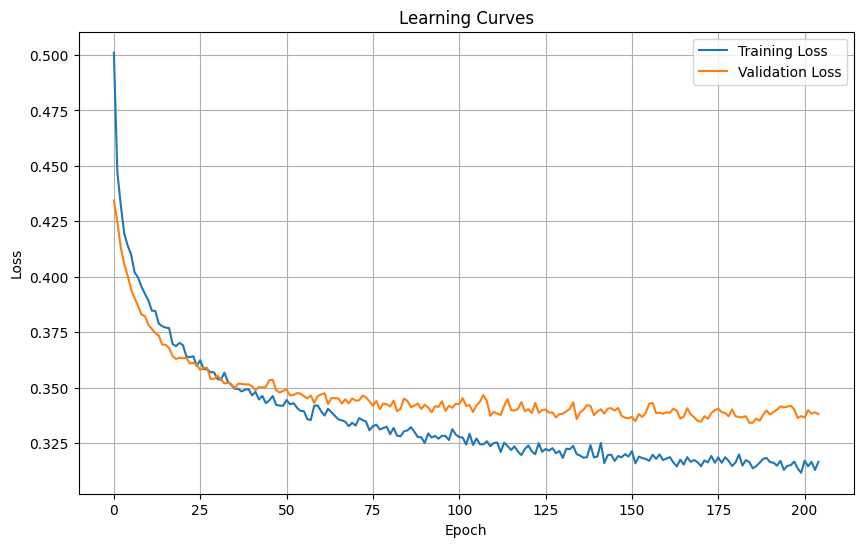

In [29]:
# Plotting the learning curves
plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.legend()
plt.grid(True)
plt.show()

**Interpretation:**

We can visually see and confirm our results above. We can see the training loss steadily decreases, showing the model is successfully fitting the training data. We can also see that the validation loss decreases and then slighlty plateaus, suggesting that the model is generalizing well to unseen data and not overfitting. I would say that this small gap between the training and validation loss shows that the model has a good balance of bias and variance. We can also see that at 205 the graphing stops and this is where early stopping kicks in, helping to select the best model so there isnt any overfitting.

# Training Evaluation

### Validation Accuracy & Classification Report

In [37]:
# Model in eval mode 
seq_model.eval()
with torch.no_grad():
    val_outputs = seq_model(X_val_tensor)  # predictions on the validation set
    val_preds = torch.argmax(val_outputs, dim=1)

# Convert to numpy
y_true = y_val_tensor.numpy()
y_pred = val_preds.numpy()

# Validation Classification Report
print("Validation Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Not Canceled", "Canceled"]))

Validation Classification Report:
              precision    recall  f1-score   support

Not Canceled       0.91      0.87      0.89      3898
    Canceled       0.76      0.82      0.79      1900

    accuracy                           0.86      5798
   macro avg       0.83      0.85      0.84      5798
weighted avg       0.86      0.86      0.86      5798



**Interpretation:**

We can see that the model is performing pretty well overall, with an accuracy of **86%** on the validation set. 

It was especially strong at identifying not canceled bookings, with a high precision of **91%** and a recall of **87%**, so when it predicts a customer will not cancel, it is usually correct and accurate. 

For canceled bookings on the other hand, the model had a precision of **76%** and a recall of **82%**, which means that it is mostly reliable at detecting cancellations. However, it is a bit more prone to false positives, or predicting a cancellation when it doesn't happen. 

The F1 scores are 0.89 for not canceled and 0.79 for canceled, showing that there is a strong overall performance with a slight drop in consistency when predicting cancellations. The macro and weighted averages also suggest that the model is doing a good job of balancing both classes even though they are different sizes. 

# Final Test Evaluation

### Final Test Accuracy & Classification Report

In [38]:
# Model in eval mode
seq_model.eval()
with torch.no_grad():
    test_outputs = seq_model(X_test_tensor) # predictions on the test set
    test_preds = torch.argmax(test_outputs, dim=1)

# Convert to numpy
y_test_true = y_test_tensor.numpy()
y_test_pred = test_preds.numpy()

# Classification report
from sklearn.metrics import classification_report

print("Final Test Classification Report:")
print(classification_report(y_test_true, y_test_pred, target_names=["Not Canceled", "Canceled"]))

Final Test Classification Report:
              precision    recall  f1-score   support

Not Canceled       0.90      0.87      0.89      4872
    Canceled       0.75      0.81      0.78      2376

    accuracy                           0.85      7248
   macro avg       0.83      0.84      0.83      7248
weighted avg       0.85      0.85      0.85      7248



**Interpretation:**

We can see that the model is generalizing well since it is pretty much the same as the Validation Classification Report! We can see that on the test set, the model performed really well, achieving an overall accuracy of **85%**. It was really good at identifying non-canceled bookings as before and had a hard time with cancelation precision. 

Overall, this is a good and well balanced model with room to slightly improve how it identifies canceled bookings which is very imortant for the business objective.

### Plot Confusion Matrix

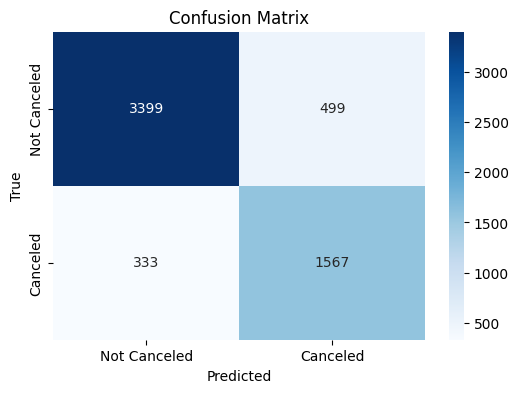

In [39]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Not Canceled", "Canceled"],
            yticklabels=["Not Canceled", "Canceled"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

**Interpretation:**

We can see that the confusion matrix confirms what we just saw when evaluating the model. The model correctly classified over 3400 non cancellations and about 1560 cancellations. However, it still missed about 330 cancellations and incorrectly flagged around 500 bookings as canceled when they were not. Looking at this, the model is capturing both of these classes pretty good, but there is definetly room to improve how precise it is, expecially when predicting cancellations.

### Test Set Model Predictions

Get the fitted model predictions for the test set.

In [30]:
# Get model outputs (logits) on test set and detach from computation graph
logits = seq_model(X_test_tensor).detach()

# Convert logits to probabilities using softmax
probabilities = torch.softmax(logits, dim=1)

# Extract positive class probabilities and convert to numpy array
p_1 = probabilities[:, 1].numpy().reshape(-1)

# Create DataFrame with predicted probs and actual labels
p_1_actual = pd.DataFrame({'p_1': p_1, 'actual': y_test})

# Shuffle rows randomly
p_1_actual_shuffled = p_1_actual.sample(frac=1, random_state=42).reset_index(drop=True)

# Show results
p_1_actual_shuffled.head(10)

,p_1,actual
0,0.999985,1
1,0.150639,0
2,0.997136,1
3,0.154959,1
4,0.198720,0
5,0.267124,0
6,0.908448,1
7,0.240970,0
8,0.999910,1
9,0.962721,1


**Interpretation:**

We can see thet the model is very confident, with probabilities close to 0 or 1, in most of the predictions. There is only one error predicted where it should have been 0, was around 0.15 prob, predicting actual was 1. Even though this is a little random sample, it seems that it is overall well calibrated.

### Calculate Information for ROC curve

In [31]:
# Create ROC 
roc_data = pd.DataFrame({
    'threshold': np.arange(1, -0.01, -0.01),
    'fpr': 0.0,
    'tpr': 0.0
})

# Count total actual positives and negatives
actuals_1 = len(p_1_actual[p_1_actual['actual'] == 1])
actuals_0 = len(p_1_actual[p_1_actual['actual'] == 0])

# Loop through each threshold
for i in np.arange(1, -0.01, -0.01):
    # Get rows where prediction >= threshold
    over_threshold = p_1_actual[p_1_actual['p_1'] >= i]

    # Count true positives and false positives
    tp = len(over_threshold[over_threshold['actual'] == 1])
    fp = len(over_threshold[over_threshold['actual'] == 0])

    # Compute trp and fpr
    tpr = tp / actuals_1 if actuals_1 > 0 else 0
    fpr = fp / actuals_0 if actuals_0 > 0 else 0

    # Save to DataFrame
    roc_data.loc[roc_data['threshold'] == i, 'tpr'] = tpr
    roc_data.loc[roc_data['threshold'] == i, 'fpr'] = fpr

# Show results
print(roc_data.head(10))


   threshold       fpr       tpr
0       1.00  0.000000  0.005471
1       0.99  0.000205  0.264310
2       0.98  0.000616  0.322391
3       0.97  0.001437  0.348064
4       0.96  0.002053  0.377104
5       0.95  0.003079  0.398990
6       0.94  0.003284  0.415404
7       0.93  0.004105  0.428872
8       0.92  0.006568  0.443603
9       0.91  0.007594  0.459175


### Plot ROC curve

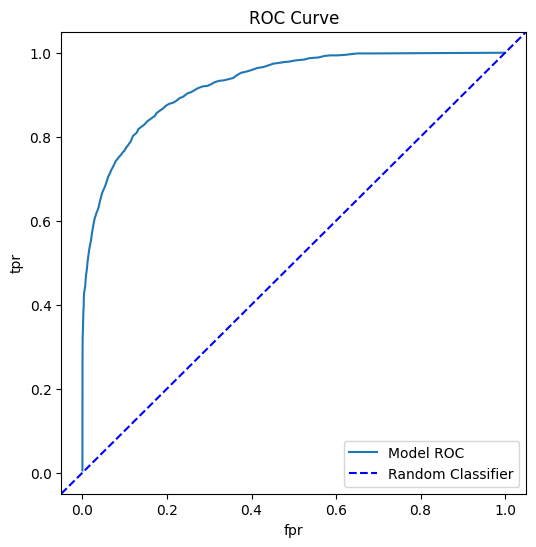

In [32]:
# Create ROC curve using seaborn
plt.figure(figsize=(6, 6))
roc = sns.lineplot(x='fpr', y='tpr', data=roc_data, label='Model ROC')

# Set limits
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)

# axis limits
xlims = roc.get_xlim()
ylims = roc.get_ylim()

# Determine diagonal line bounds
min_val = min(xlims[0], ylims[0])
max_val = max(xlims[1], ylims[1])

# Plot diagonal line
roc.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='blue', label='Random Classifier')

# Restore original limits
roc.set_xlim(xlims)
roc.set_ylim(ylims)

# labels and title
roc.set_xlabel('fpr')
roc.set_ylabel('tpr')
roc.set_title('ROC Curve')
roc.legend()

# show plot
plt.show()


We can see that the model has strong class separation, with high tpr at low fpr. Very good classifier performance.

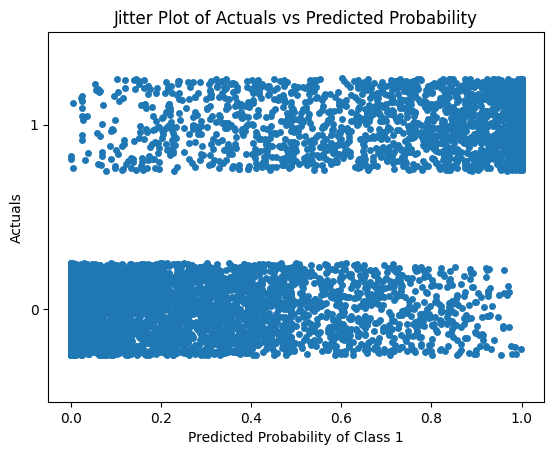

In [33]:
p_1_actual['actual'] = p_1_actual['actual'].astype(str)

# jitter plot
sns.stripplot(x='p_1', y='actual', data=p_1_actual, jitter=0.25)

# Customize the plot
plt.title('Jitter Plot of Actuals vs Predicted Probability')
plt.xlabel('Predicted Probability of Class 1')
plt.ylabel('Actuals')

# show plot
plt.show()

We can see that the models had outputs with well separated probabilities. The majority of the predicted probabilities align with the true labels, meaning that it has higher calibration and higher confidence.

# Neural Network Design Rationale

**Number of Layers:** The model is a feedforward network with two hidden layers. This setup is deep enough to capture patterns in the data but still simple and efficient to train.

**Units per Layer:** The first hidden layer has 64 units, giving the model enough capacity to learn complex relationships. The second layer has 32 units, which helps reduce the size of the learned representation and limits overfitting.

**Activation Functions:** Both hidden layers use ReLU, which is fast to compute and avoids common training problems like vanishing gradients. The output layer has 2 units (canceled vs. not canceled). No activation is applied there because CrossEntropyLoss in PyTorch automatically applies softmax.

**Loss Function:** The model uses CrossEntropyLoss with class weights. This is the standard choice for classification tasks, and the weights help the model pay more attention to the minority class (cancellations).

**Optimization Algorithm:** Training is done with the Adam optimizer (learning rate = 0.001). Adam adapts learning rates automatically and usually converges faster than basic gradient descent.

**Regularization:** I applied dropout regularization after each hidden layer, with rates of 0.3 after the first layer and 0.2 after the second to help prevent overfitting. 

# Future Improvements and Next Steps

**Introduce dropout or L2 regularization:** This can help the model generalize better and avoid overfitting by reducing reliance on specific training examples.

**Experiment with a deeper or wider model:** I can try adding additional hidden layers or increasing the number of units per layer (from [64 → 32] to [64 → 64 → 32]), which may allow the model to find more complex patterns in the data.

**Compare with simpler models:** Testing models like logistic regression or random forests can help determine if a simpler and more interpretable model can achieve similar results with less complexity.

**Make the model more explainable:** I can use SHAP to help explain which features are most influencial for the models predictions.

**Remove irrelevant or redundant features:** I can find and eliminating features that are not contributing to the models predictive power. This can help simplify the model, reduce training time, and help prevent overfitting.

**Hyperparameter tuning:** I can play around with adjusting parameters like learning rate, batch size, and number of units per layer to find the best model setup.